In [1]:
# import internal files
import emulators
import sample
import historymatch
import plot

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

plt.rcParams.update({'font.size': 10})

np.random.seed(4)

import importlib

In [2]:
def model_eqn_1(x, theta_0, theta_1, theta_2):
    return theta_0 + theta_1*(x) + theta_2*(x**2)

function1 = np.vectorize(model_eqn_1)

In [3]:
def model_eqn_2(x, theta_0, theta_1, theta_2):
    return theta_0 - theta_1*np.sin(x) + theta_2*np.cos(x)

function2 = np.vectorize(model_eqn_2)

In [19]:
# define parameter space
x_bound = np.array([0.1, 1])
Nx = 8
xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

theta_0_bound = np.array([-1, 1]).reshape(1,-1)
theta_1_bound = np.array([-1, 1]).reshape(1,-1)
theta_2_bound = np.array([-1, 1]).reshape(1,-1)

parameter_bounds = np.concatenate((theta_0_bound, theta_1_bound, theta_2_bound), axis=0)

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)

theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), theta_2_vals.reshape(1,-1)), axis=0)

In [20]:
def generate_functions(xvals):
    funclist = []
    
    for x in xvals:
        def model_eqn_1(theta_0, theta_1, theta_2):
            return theta_0 + theta_1*(x) + theta_2*(x**2)
        funclist.append(model_eqn_1)
        
    for x in xvals:
        def model_eqn_1(theta_0, theta_1, theta_2):
            return theta_0 + theta_1*(x) + theta_2*(x**2)
        funclist.append(model_eqn_1)
        
        
    return funclist

In [21]:
true_model = []

def make_eqn1(x):
    def f(theta_0, theta_1, theta_2):
            return theta_0 + theta_1*(x) + theta_2*(x**2)
    return f

def make_eqn2(x):
    def f(theta_0, theta_1, theta_2):
            return theta_0 - theta_1*np.sin(x) + theta_2*np.cos(x)
    return f

for x in xvals:
    true_model.append(make_eqn1(x))
    
for x in xvals:
    true_model.append(make_eqn2(x))


In [22]:
# generate observational data with some uncertainty
true_parameters = [-0.1, 0.3, 0.6]
ndim = len(true_parameters)

var_exp_f1 = 0.001        # observational uncertainty variance
var_exp_f2 = 0.001

error_f1 = np.random.normal(0, var_exp_f1, len(xvals))
error_f2 = np.random.normal(0, var_exp_f2, len(xvals))

z_1 = model_eqn_1(xvals, true_parameters[0], true_parameters[1], true_parameters[2]) + error_f1 # observed datapoint

z_2 = model_eqn_2(xvals, true_parameters[0], true_parameters[1], true_parameters[2]) + error_f2  # observed datapoint

obs_data = np.concatenate((z_1,z_2))

print(obs_data)

[-0.06367882 -0.00101304  0.08279507  0.18556506  0.31056538  0.4529021
  0.61847192  0.79839888  0.46642922  0.41642852  0.35670219  0.29174984
  0.21813282  0.13758592  0.05680096 -0.02669339]


In [23]:
# solve analytically

def design_matrix_f1(x, p=3):
    X_d = np.zeros((len(x),p))
    for i in range(p):
        X_d[:,i] = x**i
    return X_d

def design_matrix_f2(x, p=3):
    X_d = np.zeros((len(x),p))
    X_d[:,0] = 1
    X_d[:,1] = -np.sin(x)
    X_d[:,2] = np.cos(x)
    return X_d


# Create design matrix
X1 = design_matrix_f1(xvals, p=3)
X2 = design_matrix_f2(xvals, p=3)

def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

A1 = A_matrix(X1, var_exp_f1)
b1 = z_1 / np.sqrt(var_exp_f1)

A2 = A_matrix(X2, var_exp_f2)
b2 = z_2 / np.sqrt(var_exp_f2)

def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

cov_matrix_f1 = covariance(X1, var_exp_f1)
cov_matrix_f2 = covariance(X2, var_exp_f2)
theta_f1 = solve_theta(A1, b1)
theta_f2 = solve_theta(A2, b2)

true_thetas = [theta_f1, theta_f2]


H1 = H_matrix(A1)
H2 = H_matrix(A2)

print(theta_f1)

H12inv = np.linalg.inv(H1) + np.linalg.inv(H2)
#H12 = np.linalg.inv(H12inv)

#print(H12)

#H12 = (H1 + H2)/2


H12 = np.matmul(H1, np.matmul(np.linalg.inv(H1 + H2),H2))


[-0.10003191  0.29737162  0.60232968]


In [24]:
def plot_ellipses(fig, parameter_bounds, true_parameters, H, theta_best, theta_vals, color):
    theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$']
    N = len(theta_best)
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                None
                #if color == 'mediumaquamarine':
                    #ax_right = ax.twinx()
                    #ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                    #ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                
            elif i < j:
                
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                ax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
            else:
                ax.axis('off')

In [25]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot(centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    ax.scatter(centre[0], centre[1], marker='x', color=color)
        
    #return Ellipse(xy=centre, width=width, height=height,
                   #angle=np.degrees(theta), **kwargs)

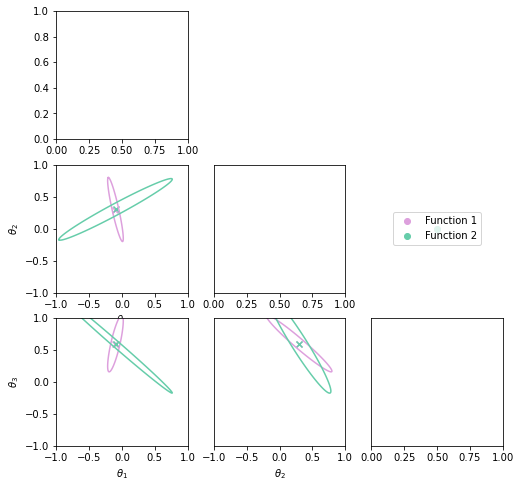

In [26]:
color_list = ['plum', 'mediumaquamarine']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(8,8))

ax = fig.axes[5]
plot_ellipses(fig, parameter_bounds, true_parameters, H1, theta_f1, theta_vals, color_list[0])
plot_ellipses(fig, parameter_bounds, true_parameters, H2, theta_f2, theta_vals, color_list[1])
ax.scatter(1,1,color=color_list[0],label='Function 1')
ax.scatter(1,1,color=color_list[1],label='Function 2')
ax.legend(loc='center')

#plot_ellipses(fig, parameter_bounds, true_parameters, H12, theta_f1, theta_vals, 'red')

In [47]:
nwaves = 4
ndim = 3

In [48]:
HM = historymatch.HistoryMatch(obs_data,
                               ndim, true_model, 'GP', 'ellipsoid',
                               parameter_bounds, var_exp_f1, 0.001)

results = HM.run(nwaves=nwaves)

Running wave 1


KeyboardInterrupt: 

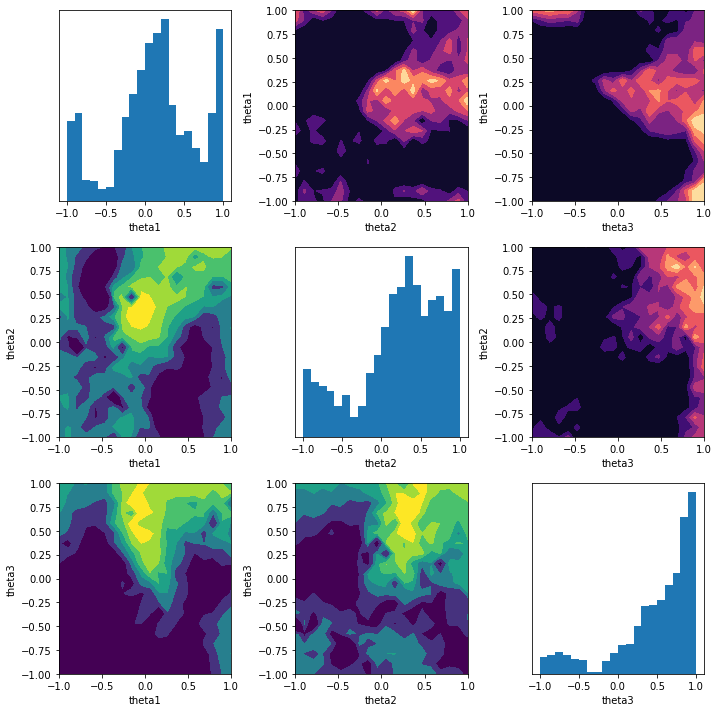

In [56]:
importlib.reload(plot)

fig, axes = plt.subplots(ndim,ndim,figsize=(10,10))
#plot.opticaldepth_1D(results.samples[0], parameter_bounds[0], parameter = 0, bins=20, Fig=(fig,ax1))
    
#plot.plot_implausibility2D(results.samples[0], parameter_bounds, [0,1], bins=20)

plot.plotcorner(results.samples[0], parameter_bounds, 3, Fig=(fig,axes), labels=('theta1', 'theta2', 'theta3'))

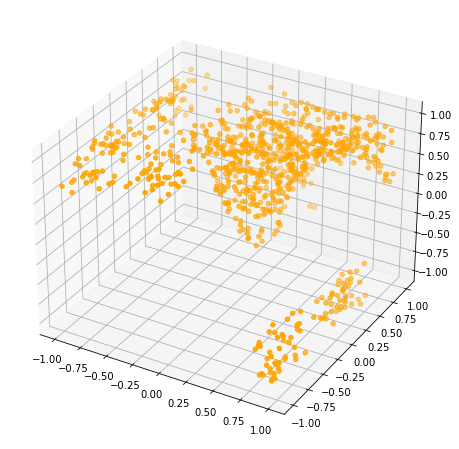

In [61]:
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')

theta_test = results.test_pts
nonimp = results.regions

ax.scatter(nonimp[0][:,0], nonimp[0][:,1], nonimp[0][:,2], color='orange')
#ax.scatter(theta_test[1][:,0], theta_test[1][:,1], theta_test[1][:,2], color='blue')


